
# YOLOv1
> 입력 448, 7×7 grid, 2 boxes/cell, C=클래스 수

**Pipeline**

1) 환경 체크 & unzip  
2) JSON 라벨 파싱(한국어 라벨) 및 클래스 자동생성  
3) 전처리/증강(letterbox 448)  
4) YOLOv1 모델(간결 CNN + conv head)  
5) 손실 함수(YOLOv1 방식: 책임 박스 할당, sqrt(w,h))  
6) 학습/검증 루프  
7) 추론(디코드+NMS) & 시각화


## 1) 환경 체크

In [ ]:

import torch, os, json, random, shutil, math, zipfile
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance, ImageDraw

print("PyTorch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


PyTorch: 2.6.0+cu124
CUDA: True


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2) 데이터셋 Unzip & 라벨 파싱

In [ ]:
# 사용할 데이터 압축 파일 경로
zip_candidates = [Path("/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/drawings.zip")]

zip_path = None
# zip 파일 선택
for c in zip_candidates:
    if c.exists():
        zip_path = c
        break
if zip_path is None:
    raise FileNotFoundError("drawings.zip 업로드/경로 확인!")
print("Using zip:", zip_path)

# 압축 해제될 루트 폴더 준비
root = Path("./data_drawings_v1")
if root.exists():
    shutil.rmtree(root) # 이미 있으면 삭제
root.mkdir(parents=True, exist_ok=True) # 새로 생성

# 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(root)

# 원천 데이터(이미지) 폴더와 라벨 데이터(JSON) 폴더 경로 탐색
src_dir = next(root.glob("**/01.원천데이터"))
lbl_dir = next(root.glob("**/02.라벨링데이터"))
print("원천:", src_dir)
print("라벨:", lbl_dir)

# JSON 라벨 파싱 함수 정의
def parse_json(json_path: Path):
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)

    meta = d.get("meta", {}) # 메타 정보 (이미지 경로 등)
    ann = d.get("annotations", {}) # 어노테이션 정보 (bbox, class 등)

    bboxes = ann.get("bbox", []) # 바운딩 박스 목록
    img_rel = meta.get("img_path") # JSON 안에 기록된 이미지 상대 경로
    img_path = (json_path.parent / Path(img_rel)).resolve() # 절대경로로 변환

    # 만약 JSON 안의 경로에 이미지가 없으면 원천데이터 폴더에서 검색
    if not img_path.exists():
        cands = list(src_dir.rglob(img_path.name))
        if cands:
            img_path = cands[0]
    return {"img_path": img_path, "bboxes": bboxes, "class": ann.get("class","")}

# 모든 JSON 파일 읽어서 파싱
from collections import Counter
json_list = sorted(lbl_dir.rglob("*.json")) # 라벨 폴더 안의 모든 JSON 리스트
items = [] # 유효한 이미지+라벨 정보 저장
label_counter = Counter() # 클래스별 카운트 저장

for jp in json_list:
    info = parse_json(jp)
    if not info["img_path"].exists(): # 이미지가 실제 없으면 skip
        continue

    # bbox 안에 들어있는 label 통계 집계
    for bb in info["bboxes"]:
        label_counter[bb.get("label","UNKNOWN")] += 1
    items.append(info)

print("유효 이미지 수:", len(items))
print("라벨 상위20:", label_counter.most_common(20))

# 클래스 목록 & 매핑 테이블 생성
classes = sorted(label_counter.keys()) # 등장한 라벨들을 알파벳 순으로 정렬
cls2idx = {c:i for i,c in enumerate(classes)} # 라벨명 → 인덱스
idx2cls = {i:c for c,i in cls2idx.items()} # 인덱스 → 라벨명
# YOLO 같은 딥러닝 모델은 문자열("고양이") 대신 숫자 인덱스(예: 1) 로 학습해야 하니,
# 학습할 때: "고양이" → 1 (cls2idx 사용)
# 결과 해석할 때: 1 → "고양이" (idx2cls 사용)
# 이런 변환을 하려고 두 개를 만들어둔 것.

num_classes = len(classes) # 전체 클래스 수

# 클래스 개수와 일부 클래스 이름 출력
num_classes, classes[:15]


Using zip: /content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/drawings.zip
원천: data_drawings_v1/Sample/01.원천데이터
라벨: data_drawings_v1/Sample/02.라벨링데이터
유효 이미지 수: 560
라벨 상위20: [('꽃', 637), ('눈', 560), ('팔', 560), ('발', 560), ('운동화', 560), ('다리', 559), ('귀', 557), ('손', 557), ('잔디', 525), ('주머니', 517), ('나뭇잎', 509), ('별', 485), ('열매', 477), ('단추', 290), ('사람전체', 280), ('머리', 280), ('얼굴', 280), ('코', 280), ('입', 280), ('머리카락', 280)]


(47,
 ['가지',
  '구름',
  '굴뚝',
  '귀',
  '그네',
  '기둥',
  '길',
  '꽃',
  '나무',
  '나무전체',
  '나뭇잎',
  '남자구두',
  '눈',
  '다람쥐',
  '다리'])

## 3) 전처리 & 데이터셋 (letterbox 448, S=7, B=2)

In [ ]:
# YOLOv1 기본 설정값
INPUT_SIZE = 448 # 입력 이미지 크기 (448x448)
S = 7 # Grid 크기 (7x7)
B = 2 # 박스 수 (cell 당 2개 예측)
STRIDE = INPUT_SIZE // S  # 448 / 7 = 64, grid cell 하나의 픽셀 크기

# Letterbox Resize (비율 유지 + 패딩)
def letterbox(im: Image.Image, new_size=INPUT_SIZE, color=(114,114,114)):
    w,h = im.size
    # 스케일 비율 계산 (가로, 세로 중 더 작은 비율 사용)
    scale = min(new_size/w, new_size/h)
    nw, nh = int(w*scale), int(h*scale)

    # 이미지 리사이즈
    im_resized = im.resize((nw, nh), Image.BILINEAR)

    # 빈 캔버스(448x448)에 회색 배경 채우기
    canvas = Image.new('RGB', (new_size,new_size), color)

    # 남는 부분은 중앙 정렬을 위해 패딩
    pad_x = (new_size - nw)//2
    pad_y = (new_size - nh)//2
    canvas.paste(im_resized, (pad_x, pad_y))

    return canvas, scale, pad_x, pad_y

# HSV 색상 증강 (색감, 밝기 변형)
def augment_hsv(im: Image.Image, sgain=0.5, vgain=0.4):
    s_factor = 1 + (random.random()*2-1)*sgain # 채도 조절
    v_factor = 1 + (random.random()*2-1)*vgain # 밝기 조절
    im = ImageEnhance.Color(im).enhance(s_factor)
    im = ImageEnhance.Brightness(im).enhance(v_factor)
    return im

# 랜덤 좌우 반전 (Horizontal Flip)
def random_hflip(im: Image.Image, boxes):
    if random.random()<0.5: # 50% 확률로 반전
        w,h = im.size
        im = ImageOps.mirror(im)
        nboxes = []
        for x,y,bw,bh,cls in boxes:
            # 좌우 반전된 좌표 계산
            nx = w - (x + bw)
            nboxes.append([nx,y,bw,bh,cls])
        return im, nboxes
    return im, boxes

# GT → YOLOv1 Target Tensor 변환
def build_target_yolov1(boxes, num_classes, s=S):
    """
    YOLOv1 target tensor: shape (S, S, B*5 + C)
    - 각 셀(cell)에는 최대 1개 객체만 할당(가장 큰 면적 선택)
    - tx, ty: 셀 내부 오프셋(0~1)
    - tw, th: sqrt 규약(이미지 크기 448을 기준으로 정규화 후 제곱근)
    - 두 박스의 좌표 타겟은 동일하게 채우고, '책임 박스'는 손실 계산 단계에서 IoU가 큰 예측 박스로 선택
    """
    T = np.zeros((s, s, B*5 + num_classes), dtype=np.float32)
    per_cell = {}

    # 각 grid cell에 가장 큰 객체만 할당
    for (x,y,w,h,cls) in boxes:
        cx, cy = x + w/2, y + h/2
        gx, gy = int(cx//STRIDE), int(cy//STRIDE)
        if gx<0 or gy<0 or gx>=s or gy>=s:
            continue
        area = w*h
        if (gy,gx) not in per_cell or area > per_cell[(gy,gx)][2]*per_cell[(gy,gx)][3]:
            per_cell[(gy,gx)] = [x,y,w,h,cls]

    # 각 cell에 대해 target tensor 값 채우기
    for (gy,gx), (x,y,w,h,cls) in per_cell.items():
        cx, cy = x + w/2, y + h/2
        tx = (cx/STRIDE) - gx # 셀 내부 오프셋
        ty = (cy/STRIDE) - gy
        tw = math.sqrt(max(w, 1e-6) / INPUT_SIZE) # sqrt 규약
        th = math.sqrt(max(h, 1e-6) / INPUT_SIZE)

        for b in range(B): # 두 개 박스 모두 같은 값으로 채움
            base = b*5
            T[gy,gx,base+0] = tx
            T[gy,gx,base+1] = ty
            T[gy,gx,base+2] = tw
            T[gy,gx,base+3] = th
            T[gy,gx,base+4] = 1.0  # objectness target placeholder

        # 클래스 one-hot
        T[gy,gx, B*5 + cls] = 1.0
    return T

# Dataset 클래스 정의
class DrawingsV1(torch.utils.data.Dataset):
    def __init__(self, items, cls2idx, input_size=INPUT_SIZE, augment=True):
        self.items = items
        self.cls2idx = cls2idx
        self.input_size = input_size
        self.augment = augment

    def __len__(self):
      return len(self.items)

    def __getitem__(self, idx):
        info = self.items[idx]
        im = Image.open(info["img_path"]).convert("RGB")

        # 라벨 박스 파싱
        boxes = []
        for bb in info["bboxes"]:
            x,y,w,h = bb["x"], bb["y"], bb["w"], bb["h"]
            cid = self.cls2idx.get(bb.get("label",""), -1)
            if cid<0 or w<=0 or h<=0: # 잘못된 bbox는 skip
                continue
            boxes.append([x,y,w,h,cid])

        # 데이터 증강 적용
        if self.augment:
            im, boxes = random_hflip(im, boxes)
            im = augment_hsv(im)

        # letterbox 리사이즈
        im_lb, scale, pad_x, pad_y = letterbox(im, self.input_size)

        # bbox 좌표를 리사이즈/패딩 비율에 맞게 변환
        nboxes = []
        for x,y,w,h,cid in boxes:
            x = x*scale + pad_x; y = y*scale + pad_y
            w = w*scale; h = h*scale
            nboxes.append([x,y,w,h,cid])

        # YOLOv1 target tensor 생성
        T = build_target_yolov1(nboxes, num_classes=len(self.cls2idx), s=S)

        # 이미지를 Tensor로 변환 (C,H,W 순서)
        arr = np.array(im_lb).astype(np.float32)/255.0
        arr = np.transpose(arr,(2,0,1))
        img = torch.from_numpy(arr)

        tgt = torch.from_numpy(T)
        return img, tgt

# DataLoader용 collate 함수
def collate_fn(b):
    imgs = torch.stack([x[0] for x in b])
    tgts = torch.stack([x[1] for x in b])
    return imgs, tgts

# Train/Validation 분리
random.seed(42)
perm = list(range(len(items)))
random.shuffle(perm)
n_train = int(len(perm)*0.9) # 90% train / 10% validation
train_idx, val_idx = perm[:n_train], perm[n_train:]

train_items = [items[i] for i in train_idx]
val_items = [items[i] for i in val_idx]

# Dataset 객체 생성
train_ds = DrawingsV1(train_items, cls2idx, INPUT_SIZE, augment=True)
val_ds   = DrawingsV1(val_items, cls2idx, INPUT_SIZE, augment=False)

# DataLoader 정의
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

# 학습/검증 데이터셋 크기 확인
len(train_ds), len(val_ds)

# 1. letterbox / augment / hflip → 전처리 & 데이터 증강
# 2. build_target_yolov1 → bbox → YOLOv1 학습용 tensor로 변환
# 3. DrawingsV1 → Dataset 클래스, __getitem__에서 (이미지, 타겟) 반환
# 4. DataLoader → batch 단위 묶어서 학습에 사용


(504, 56)

## 4) YOLOv1 모델

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Conv → BN → LeakyReLU 블록 정의
def conv_bn_leaky(c_in, c_out, k=3, s=1, p=None):
    if p is None: p = (k-1)//2 # 기본적으로 'same padding'을 맞춤 (stride=1일 때 입력 크기 유지)
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, k, s, p, bias=False), # 합성곱 (bias는 BN으로 대체되므로 False)
        nn.BatchNorm2d(c_out), # 배치 정규화
        nn.LeakyReLU(0.1, inplace=True) # LeakyReLU 활성화 (음수 구간 기울기 0.1)
    )

# YOLOv1 모델 정의
class YOLOv1Net(nn.Module):
    def __init__(self, num_classes, S=7, B=2):
        super().__init__()
        self.S=S; self.B=B; self.C=num_classes # grid 크기 (7x7), 박스 개수 (셀당 2개), 클래스 개수

        # Backbone: 특징 추출 CNN
        # (Darknet 스타일, Conv + MaxPool 반복)
        self.backbone = nn.Sequential(
            conv_bn_leaky(3,32,3,1), nn.MaxPool2d(2,2), # 입력: 3채널 → 32채널, 다운샘플링
            conv_bn_leaky(32,64,3,1), nn.MaxPool2d(2,2), # 32 → 64채널
            conv_bn_leaky(64,128,3,1), # 64 → 128채널
            conv_bn_leaky(128,64,1,1), # 1x1 conv: 채널 축소
            conv_bn_leaky(64,128,3,1), nn.MaxPool2d(2,2), # 128 → 128 유지, 다운샘플링
            conv_bn_leaky(128,256,3,1), # 128 → 256
            conv_bn_leaky(256,128,1,1), # 256 → 128 (채널 축소)
            conv_bn_leaky(128,256,3,1), nn.MaxPool2d(2,2), # 128 → 256, 다운샘플링
            conv_bn_leaky(256,512,3,1), # 256 → 512
            conv_bn_leaky(512,256,1,1), # 512 → 256
            conv_bn_leaky(256,512,3,1), # 256 → 512
            conv_bn_leaky(512,256,1,1), # 512 → 256
            conv_bn_leaky(256,512,3,1), nn.MaxPool2d(2,2), # 256 → 512, 다운샘플링
            conv_bn_leaky(512,1024,3,1), # 512 → 1024
            conv_bn_leaky(1024,512,1,1), # 1024 → 512
            conv_bn_leaky(512,1024,3,1), # 512 → 1024
            conv_bn_leaky(1024,512,1,1), # 1024 → 512
            conv_bn_leaky(512,1024,3,1), nn.MaxPool2d(2,2), # 512 → 1024, 다운샘플링
            conv_bn_leaky(1024,1024,3,1), # 1024 유지
        )

        # Head: Detection head
        self.head = nn.Sequential(
            conv_bn_leaky(1024,1024,3,1), # 추가 conv
            nn.Conv2d(1024, self.B*5 + self.C, 1,1,0) # 1x1 conv: (B*5 + C) 출력 채널
                                                      # B*5 = 각 박스 (x,y,w,h,confidence)
                                                      # + C = 클래스 확률
        )
    def forward(self, x):
        x = self.backbone(x) # 특징 추출
        x = self.head(x) # detection head 통과
        x = x.permute(0,2,3,1).contiguous() # (N, C, H, W) → (N, H, W, C)
                                            # YOLO 타겟 형태 (S,S,B*5+C)에 맞추기 위함
        return x

# ===================
# [의도적 변경 사항]
# ===================

# 1) FC Head 대신 Conv Head 사용
#   - 원본 YOLOv1은 Flatten → FC(4096) → FC(S*S*(B*5+C)) 구조를 사용했음.
#   - 본 구현에서는 Conv(3x3) → Conv(1x1)로 head를 단순화.
#   - 이유: 파라미터 수와 연산량을 크게 줄여 학습이 가벼워지고,
#           GPU 메모리 사용량도 감소. 실용적으로는 학습 안정성이 높음.

# 2) Batch Normalization 도입
#   - 논문 YOLOv1은 BN을 거의 사용하지 않았음.
#   - 본 구현에서는 Conv 뒤에 BatchNorm을 붙여 학습 안정성 확보.
#   - 이유: 작은 배치 크기에서도 수렴이 잘 되고, 초기 학습이 안정적임.

# 3) Letterbox Resize 사용
#   - 논문에서는 종종 단순 warp-resize(왜곡 허용)를 사용.
#   - 본 구현은 letterbox 방식을 사용하여 aspect ratio를 보존.
#   - 이유: 바운딩 박스 왜곡을 줄이고 실제 탐지 성능 안정에 유리.

# 4) Backbone Depth 축소
#   - 원본 YOLOv1은 24 conv + 2 FC로 깊은 구조.
#   - 본 구현은 conv 블록을 줄인 경량화 버전.
#   - 이유: Colab 환경 등 제한된 리소스에서 빠르게 학습 가능하도록 설계.
#           핵심 아이디어(S=7 grid, B=2 box, √w√h 규약, 책임 박스 할당)는 동일하게 유지.

## 5) 손실 함수 (YOLOv1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YOLOv1Loss(nn.Module):
    def __init__(self, S=7, B=2, C=20, lambda_coord=5.0, lambda_noobj=0.5):
        super().__init__()
        self.S=S; self.B=B; self.C=C
        self.lambda_coord=lambda_coord # λ_coord = 5 (좌표 손실 가중치)
        self.lambda_noobj=lambda_noobj # λ_noobj = 0.5 (배경 박스 손실 가중치)

    # IoU 계산 함수 (xyxy 좌표계 기준)
    def iou_xyxy(self, A, B):
        """
        A, B: (..., 4) shaped tensors of [x1,y1,x2,y2]
        returns: (...,) IoU
        """
        # 좌표 분리
        ax1, ay1, ax2, ay2 = A[...,0], A[...,1], A[...,2], A[...,3]
        bx1, by1, bx2, by2 = B[...,0], B[...,1], B[...,2], B[...,3]

        # 교집합 영역 좌표
        inter_x1 = torch.maximum(ax1, bx1)
        inter_y1 = torch.maximum(ay1, by1)
        inter_x2 = torch.minimum(ax2, bx2)
        inter_y2 = torch.minimum(ay2, by2)

        # 교집합 너비/높이 (음수 방지)
        inter_w = torch.clamp(inter_x2 - inter_x1, min=0)
        inter_h = torch.clamp(inter_y2 - inter_y1, min=0)
        inter = inter_w * inter_h

        # 면적 계산
        area_a = torch.clamp(ax2-ax1, min=0) * torch.clamp(ay2-ay1, min=0)
        area_b = torch.clamp(bx2-bx1, min=0) * torch.clamp(by2-by1, min=0)

        # 합집합 면적 + epsilon
        union = area_a + area_b - inter + 1e-9
        return inter / union

    def forward(self, pred, target):
         """
        pred, target: (N, S, S, B*5 + C)
        - 각 셀은 B개의 박스 + C개의 클래스 확률을 포함
        - box b: (tx,ty,tw_sqrt,th_sqrt,conf_logit)
          * tx,ty: 셀 내부 좌표 오프셋 (0~1)
          * tw_sqrt, th_sqrt: width,height의 sqrt 정규화
          * conf_logit: objectness logit
        - class: C개의 class 확률 (pred=logits, target=one-hot)
        """
        N, S, _, D = pred.shape
        B, C = self.B, self.C
        device = pred.device

        # 박스/클래스 분리
        pred_boxes = [pred[..., b*5:(b+1)*5] for b in range(B)]
        tgt_boxes  = [target[..., b*5:(b+1)*5] for b in range(B)]
        pred_cls   = pred[..., B*5:]
        tgt_cls    = target[..., B*5:]

        # object mask (셀에 객체가 있으면 True)
        obj_mask = (tgt_boxes[0][...,4] > 0)   # (N,S,S)
        noobj_mask = ~obj_mask # 객체 없는 셀

        # grid 좌표 생성
        gy, gx = torch.meshgrid(torch.arange(S, device=device),
                                torch.arange(S, device=device),
                                indexing='ij')
        stride = (448 // S) if 'INPUT_SIZE' not in globals() else (INPUT_SIZE // S)

        # YOLOv1 포맷(box tx,ty,tw_sqrt,th_sqrt,conf)을
        # 실제 pixel 단위 [x1,y1,x2,y2] 좌표로 디코딩
        def decode(box):
            tx,ty,tw_s,th_s,conf = box[...,0],box[...,1],box[...,2],box[...,3],box[...,4]
            # 셀 중심 좌표(cx,cy)
            cx = (gx + torch.sigmoid(tx)) * stride
            cy = (gy + torch.sigmoid(ty)) * stride
            # w,h = sqrt 규약 → 제곱으로 되돌린 뒤 이미지 크기 곱
            w = (torch.clamp(tw_s, min=1e-6)**2) * (448 if 'INPUT_SIZE' not in globals() else INPUT_SIZE)
            h = (torch.clamp(th_s, min=1e-6)**2) * (448 if 'INPUT_SIZE' not in globals() else INPUT_SIZE)
            # 좌상단(x1,y1), 우하단(x2,y2)
            x1 = cx - w/2; y1 = cy - h/2; x2 = cx + w/2; y2 = cy + h/2
            return torch.stack([x1,y1,x2,y2], dim=-1), conf

        # 모든 박스 디코딩
        pred_xyxy = []
        for b in range(B):
            xyxy, conf = decode(pred_boxes[b])
            pred_xyxy.append((xyxy, conf))
        gt_xyxy, _ = decode(tgt_boxes[0]) # GT는 box0만 사용 (모든 box 동일)

        # 책임 박스 선택 (IoU 높은 박스가 담당)
        if obj_mask.any():
            iou0 = self.iou_xyxy(pred_xyxy[0][0][obj_mask], gt_xyxy[obj_mask])
            iou1 = self.iou_xyxy(pred_xyxy[1][0][obj_mask], gt_xyxy[obj_mask])
            choose_b1 = (iou1 > iou0).float()  # True면 box1이 책임, False면 box0
        else:
            choose_b1 = None

        # 손실 항목 초기화
        l_coord = torch.tensor(0.0, device=device) # 좌표 손실
        l_obj   = torch.tensor(0.0, device=device) # 객체(confidence) 손실
        l_noobj = torch.tensor(0.0, device=device) # 배경(confidence) 손실
        l_cls   = torch.tensor(0.0, device=device) # 클래스 손실

        # B개의 박스 각각 처리
        for b in range(B):
            pb = pred_boxes[b]; tb = tgt_boxes[b]
            pb_xyxy, _ = pred_xyxy[b]

            if obj_mask.any():
                # 현재 b박스가 책임지는지 마스크 계산
                if choose_b1 is None:
                    resp = obj_mask
                else:
                    resp = obj_mask.clone()
                    want = 1 if b==1 else 0
                    resp[obj_mask] = (choose_b1 == want)

                # 좌표 손실 (tx,ty, tw_sqrt, th_sqrt)
                l_coord += F.mse_loss(pb[...,0][resp], tb[...,0][resp], reduction='sum')
                l_coord += F.mse_loss(pb[...,1][resp], tb[...,1][resp], reduction='sum')
                l_coord += F.mse_loss(pb[...,2][resp], tb[...,2][resp], reduction='sum')
                l_coord += F.mse_loss(pb[...,3][resp], tb[...,3][resp], reduction='sum')

                # objectness 손실 (책임 박스일 때 IoU를 target으로 사용)
                iou_resp = self.iou_xyxy(pb_xyxy[resp], gt_xyxy[resp]).detach()
                pred_conf = torch.sigmoid(pb[...,4][resp])
                l_obj += F.mse_loss(pred_conf, iou_resp, reduction='sum')

            # no object 셀에 대한 confidence 손실
            if noobj_mask.any():
                pred_conf_no = torch.sigmoid(pb[...,4][noobj_mask])
                zeros = torch.zeros_like(pred_conf_no)
                l_noobj += F.mse_loss(pred_conf_no, zeros, reduction='sum')

        # 클래스 손실 (CrossEntropy)
        if obj_mask.any():
            tgt_idx = torch.argmax(tgt_cls[obj_mask], dim=-1)
            l_cls += F.cross_entropy(pred_cls[obj_mask], tgt_idx, reduction='sum')

        # 최종 손실 합산 (λ_coord, λ_noobj 반영)
        loss = self.lambda_coord*l_coord + l_obj + self.lambda_noobj*l_noobj + l_cls

        # 디버깅용 컴포넌트 반환
        comp = {"coord": l_coord.item(), "obj": l_obj.item(), "noobj": l_noobj.item(), "class": l_cls.item()}

        # 배치 크기(N)로 normalize 후 반환
        return loss / pred.shape[0], comp

# - λ_coord=5 좌표 손실, λ_noobj=0.5 비객체 손실
# - 책임 박스: IoU 가장 큰 박스가 담당
# - 좌표/객체/비객체 손실은 논문 그대로 구현
# - 클래스 손실만 MSE 대신 CrossEntropy 사용 (학습 안정성 개선)

## 6) 학습 / 검증

In [ ]:
from tqdm import tqdm

# 모델, 손실 함수, 최적화기 정의
model = YOLOv1Net(num_classes=num_classes, S=S, B=B).to(DEVICE)
criterion = YOLOv1Loss(S=S, B=B, C=num_classes).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

# 1 epoch 학습 함수
def train_one_epoch(model, loader, optimizer):
    model.train() # 학습 모드 (dropout, BN 동작 다르게)
    total=0.0
    pbar = tqdm(loader, desc="train") # 진행 상황(progress bar)
    for imgs, tgts in pbar:
        # GPU로 데이터 이동
        imgs = imgs.to(DEVICE, non_blocking=True).float()
        tgts = tgts.to(DEVICE, non_blocking=True).float()

        # 순전파
        preds = model(imgs)

        # 손실 계산
        loss, comp = criterion(preds, tgts)

        # 역전파 준비
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0) # gradient explosion 방지
        optimizer.step() # 파라미터 업데이트

        # 로깅
        total += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.3f}", "coord": f"{comp['coord']:.1f}",
                          "obj": f"{comp['obj']:.1f}", "noobj": f"{comp['noobj']:.1f}", "class": f"{comp['class']:.1f}"})
    return total/len(loader) # epoch 평균 손실

# 검증 함수 (gradient 없음)
@torch.no_grad()
def validate(model, loader):
    model.eval() # 평가 모드 (BN, dropout 고정)
    total=0.0
    for imgs, tgts in loader:
        imgs = imgs.to(DEVICE, non_blocking=True).float()
        tgts = tgts.to(DEVICE, non_blocking=True).float()
        preds = model(imgs)
        loss, comp = criterion(preds, tgts)
        total += loss.item()
    return total/len(loader) # epoch 평균 손실

# 전체 학습 루프
EPOCHS = 50
best = 1e9 # 최소 검증 손실 추적
for ep in range(1, EPOCHS+1):
    # 학습/검증 실행
    tl = train_one_epoch(model, train_loader, optimizer)
    vl = validate(model, val_loader)

    # 로그 출력
    print(f"[{ep:03d}] train={tl:.4f}  val={vl:.4f}")

    # 현재까지 최저 검증 손실 모델 저장
    if vl < best:
        best = vl
        torch.save({"model":model.state_dict(), "classes":classes, "S":S, "B":B}, "yolov1_drawings_best.pt")
        print("  ↳ Best model saved.")


train: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s, loss=107.516, coord=65.3, obj=14.8, noobj=113.4, class=462.4]


[001] train=124.0833  val=91.2100
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=104.451, coord=55.8, obj=8.8, noobj=71.6, class=511.8]


[002] train=93.6779  val=93.3264


train: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s, loss=78.973, coord=38.4, obj=4.6, noobj=45.6, class=412.4]


[003] train=82.7459  val=86.9142
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=72.257, coord=31.0, obj=5.0, noobj=29.5, class=403.2]


[004] train=74.6933  val=79.0229
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s, loss=63.937, coord=24.7, obj=5.5, noobj=15.6, class=374.7]


[005] train=69.1430  val=68.7876
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s, loss=44.959, coord=16.2, obj=5.2, noobj=12.5, class=267.4]


[006] train=65.0738  val=64.8139
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=59.101, coord=22.9, obj=8.0, noobj=9.4, class=345.8]


[007] train=61.6029  val=62.3935
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=40.288, coord=15.2, obj=5.8, noobj=9.0, class=235.8]


[008] train=58.1905  val=58.1001
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=42.758, coord=15.8, obj=8.2, noobj=6.8, class=251.5]


[009] train=55.1010  val=55.8291
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, loss=58.108, coord=23.5, obj=8.0, noobj=9.0, class=334.7]


[010] train=52.4966  val=53.4688
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  1.99it/s, loss=45.542, coord=17.7, obj=7.3, noobj=6.9, class=265.2]


[011] train=50.2506  val=50.8228
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:28<00:00,  2.20it/s, loss=37.685, coord=15.5, obj=7.1, noobj=5.6, class=214.1]


[012] train=48.3817  val=55.3130


train: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s, loss=47.716, coord=17.5, obj=9.4, noobj=7.4, class=280.9]


[013] train=46.8689  val=53.1337


train: 100%|██████████| 63/63 [00:32<00:00,  1.96it/s, loss=38.025, coord=12.4, obj=8.0, noobj=7.7, class=230.4]


[014] train=45.1191  val=46.7194
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=52.695, coord=20.9, obj=7.2, noobj=8.2, class=306.0]


[015] train=43.8344  val=55.4758


train: 100%|██████████| 63/63 [00:31<00:00,  1.99it/s, loss=34.856, coord=11.0, obj=8.7, noobj=6.7, class=212.0]


[016] train=42.3548  val=44.5108
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, loss=34.160, coord=14.8, obj=7.8, noobj=5.2, class=189.0]


[017] train=40.8737  val=59.8800


train: 100%|██████████| 63/63 [00:30<00:00,  2.05it/s, loss=37.293, coord=14.7, obj=9.5, noobj=7.8, class=211.5]


[018] train=39.8633  val=43.0417
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s, loss=41.739, coord=12.3, obj=8.7, noobj=8.5, class=259.6]


[019] train=38.5498  val=42.4377
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, loss=30.844, coord=10.6, obj=8.2, noobj=7.7, class=181.7]


[020] train=37.5026  val=41.1544
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=26.309, coord=9.8, obj=7.9, noobj=6.1, class=150.4]


[021] train=35.9735  val=40.7481
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s, loss=36.893, coord=12.9, obj=9.1, noobj=8.4, class=217.1]


[022] train=34.5706  val=40.4347
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s, loss=25.604, coord=10.1, obj=8.8, noobj=8.3, class=141.5]


[023] train=33.5428  val=53.9877


train: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s, loss=28.237, coord=10.1, obj=10.3, noobj=7.4, class=161.4]


[024] train=32.3242  val=39.1794
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=34.086, coord=12.5, obj=10.4, noobj=9.9, class=195.0]


[025] train=31.3522  val=37.8235
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:32<00:00,  1.95it/s, loss=29.699, coord=8.9, obj=8.2, noobj=8.8, class=180.2]


[026] train=30.1925  val=37.2556
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=22.918, coord=8.0, obj=8.8, noobj=8.8, class=130.2]


[027] train=28.9796  val=47.9023


train: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=27.134, coord=9.2, obj=6.9, noobj=7.2, class=160.4]


[028] train=28.3500  val=42.6404


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=34.053, coord=11.4, obj=11.5, noobj=6.9, class=200.2]


[029] train=27.1702  val=37.4677


train: 100%|██████████| 63/63 [00:28<00:00,  2.18it/s, loss=21.099, coord=6.7, obj=9.3, noobj=7.5, class=122.2]


[030] train=26.2315  val=36.5218
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s, loss=19.411, coord=7.0, obj=7.0, noobj=7.6, class=109.5]


[031] train=25.1508  val=46.9650


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=35.285, coord=9.0, obj=13.4, noobj=7.0, class=220.5]


[032] train=24.6013  val=36.6453


train: 100%|██████████| 63/63 [00:31<00:00,  2.00it/s, loss=27.011, coord=10.8, obj=8.9, noobj=7.7, class=149.3]


[033] train=23.4181  val=35.4981
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, loss=18.130, coord=6.4, obj=7.2, noobj=7.7, class=102.1]


[034] train=22.1888  val=35.8279


train: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s, loss=14.802, coord=6.1, obj=4.6, noobj=8.4, class=79.3]


[035] train=21.3216  val=33.9024
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=20.585, coord=5.8, obj=11.2, noobj=8.3, class=120.2]


[036] train=20.5171  val=34.5301


train: 100%|██████████| 63/63 [00:31<00:00,  2.00it/s, loss=20.181, coord=5.3, obj=7.2, noobj=9.5, class=123.0]


[037] train=19.7886  val=35.7179


train: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s, loss=12.936, coord=4.7, obj=4.4, noobj=9.2, class=71.1]


[038] train=18.9749  val=32.7002
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=13.383, coord=5.0, obj=8.7, noobj=8.6, class=69.2]


[039] train=17.9323  val=34.9996


train: 100%|██████████| 63/63 [00:31<00:00,  2.00it/s, loss=17.731, coord=6.4, obj=8.5, noobj=9.5, class=96.7]


[040] train=17.2425  val=42.5512


train: 100%|██████████| 63/63 [00:30<00:00,  2.10it/s, loss=14.889, coord=3.7, obj=8.0, noobj=11.5, class=86.7]


[041] train=16.5618  val=32.7099


train: 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, loss=21.139, coord=5.7, obj=10.1, noobj=8.4, class=126.2]


[042] train=16.0006  val=33.2303


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=10.317, coord=4.0, obj=5.5, noobj=9.7, class=52.0]


[043] train=15.2031  val=32.2031
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s, loss=15.097, coord=4.6, obj=4.6, noobj=10.9, class=87.9]


[044] train=14.3370  val=40.8849


train: 100%|██████████| 63/63 [00:31<00:00,  2.03it/s, loss=17.354, coord=3.9, obj=7.6, noobj=8.6, class=107.3]


[045] train=13.5448  val=32.2030
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s, loss=11.935, coord=4.3, obj=5.7, noobj=8.4, class=64.2]


[046] train=12.9796  val=32.4345


train: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=11.095, coord=3.9, obj=6.7, noobj=8.1, class=58.3]


[047] train=12.3098  val=39.1556


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=9.705, coord=3.2, obj=6.9, noobj=9.0, class=50.3]


[048] train=11.4849  val=31.5652
  ↳ Best model saved.


train: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s, loss=9.919, coord=3.7, obj=5.7, noobj=9.4, class=50.3]


[049] train=11.3614  val=42.0448


train: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s, loss=8.979, coord=3.1, obj=5.1, noobj=8.8, class=46.7]


[050] train=10.6064  val=33.4816


## 7) 추론(디코드 + NMS) & 시각화

### **1. 디코드(Decode)**

모델 출력 : (S, S, B*5 + C) 형태

각 grid cell마다
- tx, ty (셀 안에서의 상대 좌표 오프셋)
- tw, th (sqrt 정규화된 너비/높이)
- confidence (박스 안에 객체가 있을 확률)
- class 확률 (C개)

이 값들을 **실제 이미지 좌표계 (x1, y1, x2, y2)**로 변환하는 과정 => **decode**

→ “모델 예측 텐서를 실제 bounding box로 해석한다”

---

### **2. NMS (Non-Maximum Suppression)**

모델은 같은 객체에 대해 여러 grid/박스가 겹쳐서 예측을 함.
→ 그대로 쓰면 중복 박스가 너무 많음.

NMS 알고리즘:
1. 클래스별로 confidence가 높은 순서대로 정렬
2. 가장 높은 박스를 선택
3. 이 박스와 IoU(겹침률)가 일정 기준 이상인 다른 박스들은 제거
4. 남은 박스 중 다음으로 높은 걸 선택 → 반복

👉 결국, 겹치는 박스 중에서 가장 신뢰도가 높은 것만 남기는 과정이 NMS

In [ ]:
!apt-get -y install fonts-noto-cjk # 구글 Noto CJK 글꼴(한중일 통합 폰트) 설치
!fc-cache -fv # 폰트 캐시 갱신 (새로 설치된 폰트를 시스템이 인식하도록)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 5s (11.4 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126380 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fon

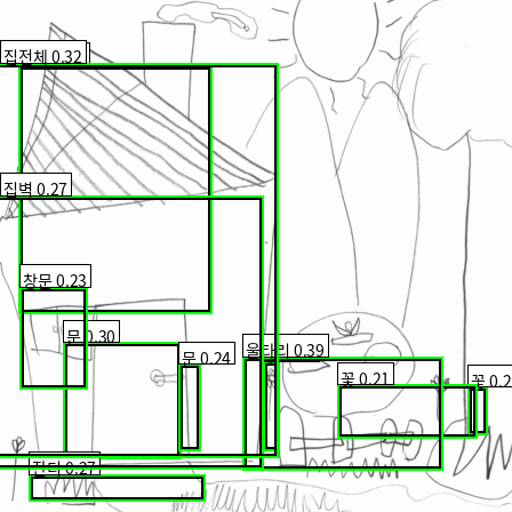

In [ ]:
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont  # 한글 글꼴/드로잉

# 유틸 함수: 수학적 변환
def sigmoid_np(x):
    return 1/(1+np.exp(-x)) # numpy 버전 시그모이드

def xywh_to_xyxy(cx,cy,w,h):
    # 중심점(cx,cy) + 너비/높이 → 좌상단/우하단 좌표(x1,y1,x2,y2)
    return [cx-w/2, cy-h/2, cx+w/2, cy+h/2]

def iou_xyxy(a,b):
    # 두 박스(x1,y1,x2,y2)의 IoU 계산
    ax1,ay1,ax2,ay2 = a
    bx1,by1,bx2,by2 = b
    inter_x1 = max(ax1,bx1); inter_y1=max(ay1,by1)
    inter_x2 = min(ax2,bx2); inter_y2=min(ay2,by2)
    inter_w = max(0.0, inter_x2-inter_x1); inter_h=max(0.0, inter_y2-inter_y1)
    inter = inter_w*inter_h
    area_a = (ax2-ax1)*(ay2-ay1); area_b=(bx2-bx1)*(by2-by1)
    union = area_a + area_b - inter + 1e-9
    return inter/union

def nms(boxes, scores, iou_th=0.5):
    """
    NMS (Non-Maximum Suppression): 겹치는 박스 중 가장 높은 점수만 남김
    """
    idxs = np.argsort(-scores) # 점수 내림차순 정렬
    keep=[]
    while len(idxs)>0:
        i = idxs[0]; keep.append(i) # 최고 점수 박스 선택
        if len(idxs)==1: break
        rest = idxs[1:]
        ious = np.array([iou_xyxy(boxes[i], boxes[j]) for j in rest])
        # IoU가 threshold 이상인 박스는 제거
        idxs = rest[ious < iou_th]
    return keep

# 폰트 + 시각화 유틸
def _get_font(size=16):
    # OS별 한글 폰트 후보 탐색
    paths = [
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",  # Colab 권장
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.otf",
        "/Library/Fonts/AppleGothic.ttf", # macOS
        "C:/Windows/Fonts/malgun.ttf", # Windows
    ]
    for p in paths:
        try:
            return ImageFont.truetype(p, size)
        except Exception:
            continue
    return ImageFont.load_default()

def _draw_boxes_pretty(img_pil, boxes, scores, labels, idx2cls,
                       base_thickness=2, base_font=16, pad=3):

    """
    박스를 굵은 라인 + 텍스트 박스로 그려 가독성 높임
    """
    W, H = img_pil.size
    scale = max(W, H) / 512.0
    th = max(2, int(base_thickness * scale)) # 선 두께
    font = _get_font(max(12, int(base_font * scale)))
    draw = ImageDraw.Draw(img_pil)

    for (x1, y1, x2, y2), s, c in zip(boxes, scores, labels):
        # 검정 테두리 → 초록 테두리 (이중선)
        draw.rectangle([x1, y1, x2, y2], outline=(0, 0, 0), width=th+2)
        draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=th)

        # 라벨 텍스트 준비
        text = f"{idx2cls[c]} {s:.2f}"
        tx1, ty1, tx2, ty2 = draw.textbbox((0, 0), text, font=font)
        tw, th_text = tx2 - tx1, ty2 - ty1

        # 텍스트 박스를 바운딩 박스 위쪽에 배치 (공간 없으면 아래쪽)
        bx1 = max(0, int(x1))
        by1 = int(y1 - th_text - 2*pad)
        if by1 < 0:
            by1 = int(y1)
        bx2 = min(W, bx1 + tw + 2*pad)
        by2 = min(H, by1 + th_text + 2*pad)

        # 흰 배경 + 검정 테두리 + 검정 글씨
        draw.rectangle([bx1, by1, bx2, by2], fill=(255, 255, 255))
        draw.rectangle([bx1, by1, bx2, by2], outline=(0, 0, 0), width=1)
        draw.text((bx1 + pad, by1 + pad), text, fill=(0, 0, 0), font=font)
    return img_pil

# =====================================

# 추론 함수 (디코드 + NMS + 시각화)
@torch.no_grad()
def infer_image(img_path, conf_th=0.2, iou_th=0.5):
    """
    1) 입력 이미지 불러오기 + letterbox resize
    2) 모델 forward → (S,S,B*5+C) 출력
    3) 각 grid cell, box별로 decode
       - tx,ty → 중심 좌표
       - tw,th → 너비/높이 (sqrt 규약 복원)
       - confidence * class 확률 = score
    4) conf threshold로 필터링
    5) 클래스별 NMS 수행
    6) 최종 박스 시각화 반환
    """
    # 필요 전역: model, letterbox, INPUT_SIZE, DEVICE, S, B, STRIDE, idx2cls
    im = Image.open(img_path).convert("RGB")
    im_lb, scale, pad_x, pad_y = letterbox(im, INPUT_SIZE)

    # tensor 변환
    arr = np.array(im_lb).astype(np.float32)/255.0
    arr = np.transpose(arr,(2,0,1))
    t = torch.from_numpy(arr).unsqueeze(0).to(DEVICE)

    # 모델 예측
    out = model(t)[0].cpu().numpy()  # (S, S, B*5 + C)

    boxes_all=[]; scores_all=[]; labels_all=[]
    for gy in range(S):
        for gx in range(S):
            cell = out[gy, gx]
            # 클래스 확률 softmax
            cls_logits = cell[B*5:]
            exp = np.exp(cls_logits - cls_logits.max())
            cls_prob = exp/exp.sum() if exp.sum()>0 else np.zeros_like(exp)

            for b in range(B):
                base = b*5
                tx,ty,tw_s,th_s,conf_logit = cell[base:base+5]
                obj = sigmoid_np(conf_logit)
                cx = (sigmoid_np(tx) + gx) * STRIDE
                cy = (sigmoid_np(ty) + gy) * STRIDE
                w = (max(tw_s, 1e-6)**2) * INPUT_SIZE
                h = (max(th_s, 1e-6)**2) * INPUT_SIZE
                x1,y1,x2,y2 = xywh_to_xyxy(cx,cy,w,h)

                # 클래스 스코어 선택
                cidx = int(np.argmax(cls_prob)) if cls_prob.sum()>0 else 0
                score = obj * (cls_prob[cidx] if cls_prob.sum()>0 else obj)

                # confidence threshold 적용
                if score < conf_th:
                    continue
                boxes_all.append([x1,y1,x2,y2])
                scores_all.append(float(score))
                labels_all.append(cidx)

    # 박스가 하나도 없으면 원본 이미지 반환
    if len(boxes_all)==0:
        return im_lb, ([], [], [])

    # numpy array 변환
    boxes_all = np.array(boxes_all, dtype=np.float32)
    scores_all = np.array(scores_all, dtype=np.float32)
    labels_all = np.array(labels_all, dtype=np.int32)

    # 클래스별 NMS 수행
    final_boxes=[]; final_scores=[]; final_labels=[]
    for c in np.unique(labels_all):
        idxs = np.where(labels_all==c)[0]
        keep = nms(boxes_all[idxs], scores_all[idxs], iou_th)
        for k in keep:
            final_boxes.append(boxes_all[idxs][k].tolist())
            final_scores.append(float(scores_all[idxs][k]))
            final_labels.append(int(c))

    # 시각화
    draw = im_lb.copy()
    draw = _draw_boxes_pretty(draw, final_boxes, final_scores, final_labels, idx2cls)
    return draw, (final_boxes, final_scores, final_labels)

# 실행 예시
sample_img = train_items[0]["img_path"]
drawn, _ = infer_image(sample_img, conf_th=0.2, iou_th=0.5)
display(drawn.resize((512,512)))


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# 한글 폰트 로더
def _get_font(size=18):
    paths = [
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.otf",
        "/Library/Fonts/AppleGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
    ]
    for p in paths:
        try:
            return ImageFont.truetype(p, size)
        except Exception:
            pass
    return ImageFont.load_default() # 없으면 기본 폰트 반환


# bbox dict → (x1,y1,x2,y2) 픽셀 좌표 변환
# - 다양한 키 이름을 지원(x,y,w,h 또는 x1,y1,x2,y2)
# - 정규화(0~1) 값도 처리하여 실제 픽셀 단위로 변환

def _to_xyxy_from_dict(bb, W, H):
    """
    bb: dict. 허용 키
      - 좌표: x,y,w,h  또는  x1,y1,x2,y2  (정규화[0~1] 또는 픽셀)
    반환: (x1,y1,x2,y2) 픽셀 좌표
    """
    # 값 꺼내기(여러 키 케이스 지원)
    x  = bb.get("x",  bb.get("xmin",  bb.get("left",  None)))
    y  = bb.get("y",  bb.get("ymin",  bb.get("top",   None)))
    w  = bb.get("w",  bb.get("width", None))
    h  = bb.get("h",  bb.get("height",None))
    x1 = bb.get("x1", bb.get("xmin",  None))
    y1 = bb.get("y1", bb.get("ymin",  None))
    x2 = bb.get("x2", bb.get("xmax",  None))
    y2 = bb.get("y2", bb.get("ymax",  None))

    if x is not None and y is not None and w is not None and h is not None:
        # (x,y,w,h)
        # 정규화 좌표이면 이미지 크기 곱해서 픽셀 단위로 변환
        if max(float(w), float(h), float(x), float(y)) <= 1.0:
            x, y, w, h = x*W, y*H, w*W, h*H
        return float(x), float(y), float(x+w), float(y+h)

    if x1 is not None and y1 is not None and x2 is not None and y2 is not None:
        # (x1,y1,x2,y2) 방식
        if max(float(x1), float(y1), float(x2), float(y2)) <= 1.0:
            x1, y1, x2, y2 = x1*W, y1*H, x2*W, y2*H
        return float(x1), float(y1), float(x2), float(y2)

    raise ValueError(f"bbox dict에서 좌표 키를 찾을 수 없습니다: {bb.keys()}")

# GT 박스를 이미지에 그려주는 함수
# - 이미지 열고, bbox dict 리스트를 받아 사각형 + 라벨 그려줌
def draw_ground_truth_from_bboxes(img_path, bboxes, idx2cls=None, cls2idx=None):
    """
    img_path: 이미지 경로
    bboxes: [{'x','y','w','h','label': str|int, ...}, ...] 같은 dict 리스트
    idx2cls: {int: name} (옵션)  | cls2idx: {name: int} (옵션)
    """
    im = Image.open(img_path).convert("RGB") # 이미지 열기
    W, H = im.size
    draw = ImageDraw.Draw(im)
    font = _get_font(18)

    for bb in bboxes:
        # 좌표 변환
        x1,y1,x2,y2 = _to_xyxy_from_dict(bb, W, H)

        # 클래스 이름 얻기
        name = None
        if "label" in bb and isinstance(bb["label"], str):
            name = bb["label"] # 문자열 라벨
        elif "class" in bb and isinstance(bb["class"], (int, np.integer)) and idx2cls:
            name = idx2cls.get(int(bb["class"]), str(bb["class"])) # 정수 → 이름
        elif "label" in bb and isinstance(bb["label"], (int, np.integer)) and idx2cls:
            name = idx2cls.get(int(bb["label"]), str(bb["label"]))
        elif "label" in bb and isinstance(bb["label"], str) and cls2idx and idx2cls:
            # 문자열 라벨 → id 매핑 후 이름
            cid = cls2idx.get(bb["label"], None)
            name = idx2cls.get(cid, bb["label"]) if cid is not None else bb["label"]
        else:
            name = str(bb.get("label", bb.get("class", "GT")))

        # 박스(빨강, 두 겹으로 테두리) 그리기
        thick = max(2, int(max(W,H)/512*2))
        draw.rectangle([x1,y1,x2,y2], outline=(0,0,0), width=thick+2) # 바깥쪽 검정
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=thick) # 안쪽 빨강

        # 라벨 텍스트 박스 (흰 배경에 검정 글씨)
        text = f"[GT] {name}"
        tx1, ty1, tx2, ty2 = draw.textbbox((0,0), text, font=font)
        tw, th = tx2-tx1, ty2-ty1
        pad = 3
        bx1 = max(0, int(x1))
        by1 = int(y1 - th - 2*pad)
        if by1 < 0: # 위에 공간 없으면 박스 안쪽에 표시
            by1 = int(y1)
        bx2 = min(W, bx1 + tw + 2*pad)
        by2 = min(H, by1 + th + 2*pad)

        # 흰색 배경 + 검정 테두리
        draw.rectangle([bx1,by1,bx2,by2], fill=(255,255,255))
        draw.rectangle([bx1,by1,bx2,by2], outline=(0,0,0), width=1)

        # 글씨 출력
        draw.text((bx1+pad, by1+pad), text, fill=(0,0,0), font=font)

    return im

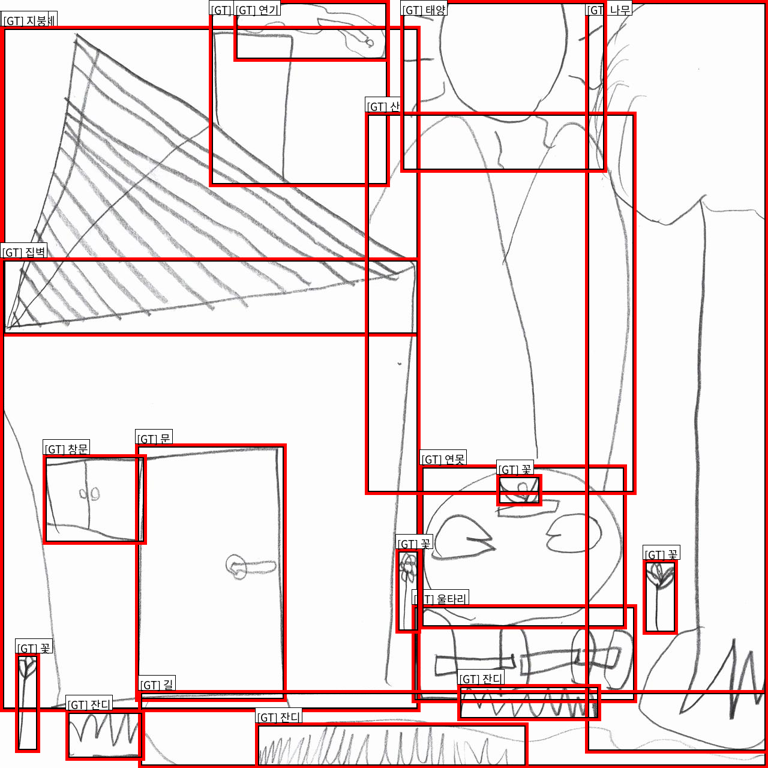

In [ ]:
# 학습 데이터에서 첫 번째 샘플의 이미지 경로 가져오기
sample_img = train_items[0]["img_path"]

# 첫 번째 샘플의 바운딩박스 정보 가져오기 (dict 리스트 형태)
sample_bboxes = train_items[0]["bboxes"]   # ← dict 리스트

# 바운딩박스를 실제 이미지에 그려주는 함수 호출
# idx2cls: 클래스 ID → 이름, cls2idx: 클래스 이름 → ID 매핑 (라벨 변환용)
gt_img = draw_ground_truth_from_bboxes(sample_img, sample_bboxes, idx2cls=idx2cls, cls2idx=cls2idx)

# 이미지 크기를 (768x768)로 리사이즈해서 화면에 표시
display(gt_img.resize((768,768)))

## 8) 배치 추론 & 저장

In [ ]:
# 예측 결과를 저장할 디렉토리 생성
out_dir = Path("./predictions_yolov1"); out_dir.mkdir(parents=True, exist_ok=True)  # 디렉토리가 없으면 새로 생성 (부모 디렉토리까지 포함)

# 검증 데이터셋(val_items)에서 앞 30개 이미지를 대상으로 예측 수행
for it in val_items[:30]:
    # 이미지 추론 (바운딩 박스 그려진 이미지와 결과값 반환)
    drawn, _ = infer_image(it["img_path"], conf_th=0.2, iou_th=0.5)

    # 저장할 파일 경로 지정 (원본 이미지 이름 + "_pred.jpg" 붙여서 저장)
    save_p = out_dir / (Path(it["img_path"]).stem + "_pred.jpg")

    # 시각화된 결과 이미지 저장
    drawn.save(save_p)

# 저장된 디렉토리 절대 경로 출력
print("Saved to:", out_dir.resolve())

Saved to: /content/predictions_yolov1
